# Amélioration des coûts de production avec prévisions de production fatale et stockage

## Importer les données annuelles de la PPE

In [2]:
import pandas as pd

In [12]:
data = pd.read_excel('historic_data.xlsx')
data = data.drop(['Unnamed: 8', 'moyen à considérer comme'], axis=1).set_index('Date')

In [13]:
data.head()

,Consommation (MW),Thermique (MW),Bagasse/charbon (MW),Hydraulique (MW),Photovoltaïque (MW),Eolien (MW),Bioénergies (MW)
Date,,,,,,,
2017-01-01 04:00:00,258.452,29.471,198.937,29.183,-0.434,-0.059,1.353
2017-01-01 05:00:00,251.673,30.472,194.092,26.283,-0.427,-0.060,1.313
2017-01-01 06:00:00,242.021,30.010,181.286,29.805,-0.359,-0.062,1.341
2017-01-01 07:00:00,233.028,24.341,173.220,22.226,11.997,-0.042,1.285
2017-01-01 08:00:00,245.900,14.836,163.957,19.252,46.460,0.030,1.365


In [20]:
data['Fatal (MW)'] = data['Photovoltaïque (MW)'] + data['Eolien (MW)'] + data['Bioénergies (MW)'] + data['Hydraulique (MW)']

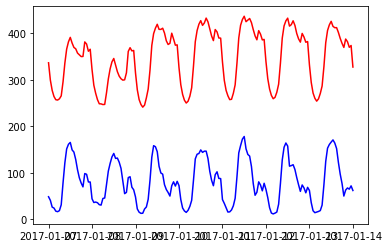

In [22]:
week = data.loc['2017-01-07 00:00':'2017-01-14 00:00']
demand = week['Consommation (MW)']
plt.plot(demand, 'r')
prod_fatale = week['Fatal (MW)']
plt.plot(prod_fatale, 'b')

costs = np.array([20, 40])
power_max = np.array([400, 200])
power_min = np.array([50, 20])

## La modélisation du problème

## Implémentation sous pulp

In [1]:
import pulp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

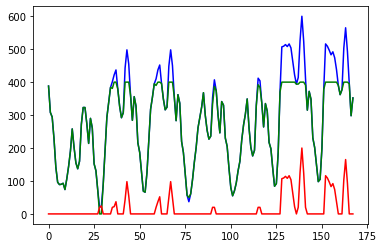

In [17]:
# minimisation problem
tprob = pulp.LpProblem("Week",pulp.LpMinimize)

# constants
p1min,p2min=power_min
p1max,p2max=power_max
c1,c2=costs
nbsteps=len(demand)

# variables

## production
p1=[pulp.LpVariable(f"p1_{t}",0,p1max) for t in range(0,nbsteps)]
p2=[pulp.LpVariable(f"p2_{t}",0,p2max) for t in range(0,nbsteps)]

## on/off
on1=[pulp.LpVariable(f"on1_{t}",cat=pulp.LpBinary) for t in range(0,nbsteps)]
on2=[pulp.LpVariable(f"on2_{t}",cat=pulp.LpBinary) for t in range(0,nbsteps)]


# constraints
for t in range(0,nbsteps):
    tprob+=p1[t]>=p1min*on1[t] # if 'on' produce at least min
    tprob+=p1[t]<=p1max*on1[t] # if 'on' produce at most max, if 'off' produce 0 
    tprob+=p2[t]>=p2min*on2[t]
    tprob+=p2[t]<=p2max*on2[t]
    
    tprob+=p1[t]+p2[t]>=demand[t]
    
for t in range(1,nbsteps-1):
    tprob+=on1[t]<=on1[t-1]+on1[t+1]
    tprob+=on2[t]<=on2[t-1]+on2[t+1]
    
# objective
tprob+=sum([p1[t]*c1 + p2[t]*c2 for t in range(0,nbsteps)])


# display
assert pulp.LpStatus[tprob.solve()] == 'Optimal'
p1res=[pulp.value(p1[t]) for t in range(0,nbsteps)]
p2res=[pulp.value(p2[t]) for t in range(0,nbsteps)]

plt.plot(demand,'b')
plt.plot(p1res,'g')
plt.plot(p2res,'r')

## Résultats